## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2024                               # What year to start the run on? (default: 2024)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/minimal_menace')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/minimal_menace.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-12-16 16:16:54.452630


{1: 24.0,
 5: 25.2,
 10: 25.9,
 20: 26.9,
 30: 27.9,
 40: 29.6,
 50: 31.3,
 60: 33.1,
 70: 35.0,
 80: 37.4,
 90: 41.0,
 95: 43.8,
 99: 49.7}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-12-16 16:33:12.670497


{1: 8.2,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.7,
 40: 8.7,
 50: 8.8,
 60: 8.8,
 70: 8.9,
 80: 9.0,
 90: 9.2,
 95: 9.3,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-12-16 16:43:47.095344


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev0)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7) (version 0.28-dev0)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev0)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.05:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.6:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19),  # https://www.lesswrong.com/posts/AfH2oPHCApdKicM4m/two-year-update-on-my-personal-ai-timelines#Making_a_one_time_upward_adjustment_for__2020_FLOP_____ starts at 18, now there are H100 chips that are ~3x better. Also ~1.2x doublings since A100 came out.
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 53973.52it/s]


{1: 0.00037,
 5: 0.00084,
 10: 0.00103,
 20: 0.00116,
 30: 0.00125,
 40: 0.00134,
 50: 0.00145,
 60: 0.00163,
 70: 0.00263,
 80: 0.00658,
 90: 0.01168,
 95: 0.01484,
 99: 0.02109}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.037%',
 5: '0.084%',
 10: '0.103%',
 20: '0.116%',
 30: '0.125%',
 40: '0.134%',
 50: '0.145%',
 60: '0.163%',
 70: '0.263%',
 80: '0.658%',
 90: '1.168%',
 95: '1.484%',
 99: '2.109%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '9 billion',
 5: '21 billion',
 10: '26 billion',
 20: '29 billion',
 30: '31 billion',
 40: '34 billion',
 50: '36 billion',
 60: '41 billion',
 70: '66 billion',
 80: '165 billion',
 90: '294 billion',
 95: '373 billion',
 99: '528 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1065409.47it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00029,
 40: 0.00038,
 50: 0.0005,
 60: 0.00069,
 70: 0.00102,
 80: 0.00178,
 90: 0.00374,
 95: 0.00603,
 99: 0.0126}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.029%',
 40: '0.038%',
 50: '0.05%',
 60: '0.069%',
 70: '0.102%',
 80: '0.178%',
 90: '0.374%',
 95: '0.603%',
 99: '1.26%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '7 billion',
 40: '10 billion',
 50: '13 billion',
 60: '17 billion',
 70: '25 billion',
 80: '45 billion',
 90: '94 billion',
 95: '151 billion',
 99: '318 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 28.4 log FLOP (~25 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~60 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.4 year to a max of 0.036058% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 28.4 log FLOP - log 2023$USD 9.9 to buy TAI vs. willingness to pay log $ 9.1 - 18.5 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 28.0 max log FLOP available - TAI takes 28.3 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 9.3 - 18.7 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.3 max log FLOP available - TAI takes 28.2 log

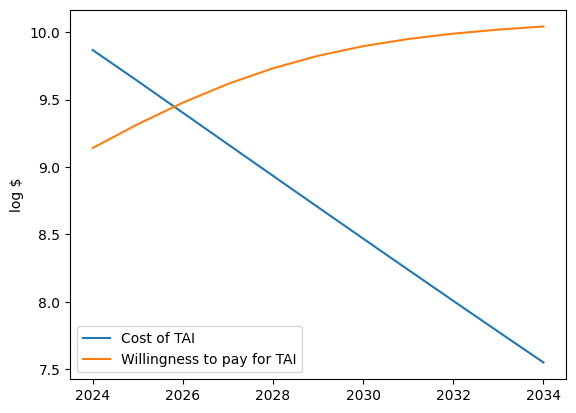

-
-
## SAMPLE RUN 2 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~30 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~307 million). This doubles every 2.2 year to a max of 0.044067% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 29.1 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 8.5 - 19.5 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.2 max log FLOP available - TAI takes 29.0 log FLOP - log 2023$USD 9.4 to buy TAI vs. willingness to pay log $ 8.6 - 19.6 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.5 max log FLOP available - TAI takes 28.

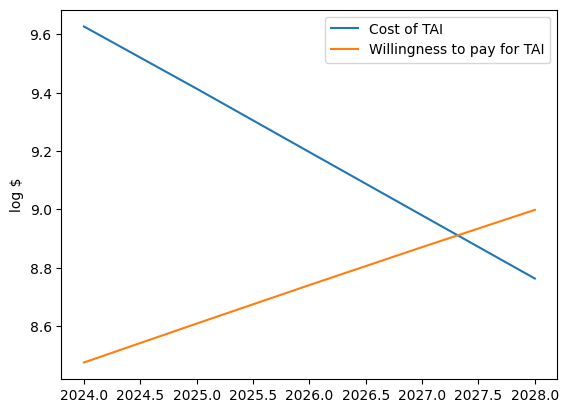

-
-
## SAMPLE RUN 3 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.4 log FLOP (~23 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~82 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~381 million). This doubles every 1.7 year to a max of 0.035318% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 31.7 log FLOP - log 2023$USD 12.3 to buy TAI vs. willingness to pay log $ 8.6 - 19.4 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.2 max log FLOP available - TAI takes 31.6 log FLOP - log 2023$USD 12.1 to buy TAI vs. willingness to pay log $ 8.7 - 19.5 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.5 max log FLOP available - TAI takes 31.

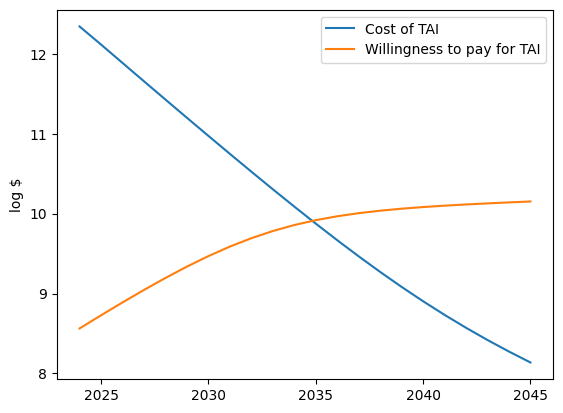

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.04it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 591.43it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2035',
 '35%: 2038',
 '50%: 2044',
 '60%: 2050',
 '75%: 2071',
 '80%: 2107',
 '90%: >2124',
 '95%: >2124']
(Mean: 2060)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 6 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 11 years from now',
 '35%: 14 years from now',
 '50%: 20 years from now',
 '60%: 26 years from now',
 '75%: 47 years from now',
 '80%: 83 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 36 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.4%
2024-2025: 0.6%
2026-2027: 1.1%
2028-2029: 3.8%
2030-2034: 16.2%
2035-2039: 18.0%
2040-2049: 19.6%
2050-2059: 10.4%
2060-2069: 5.4%
2070-2079: 2.9%
2080-2089: 1.3%
2090-2099: 0.9%

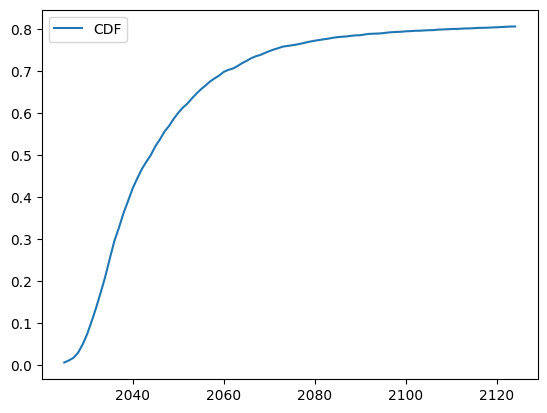

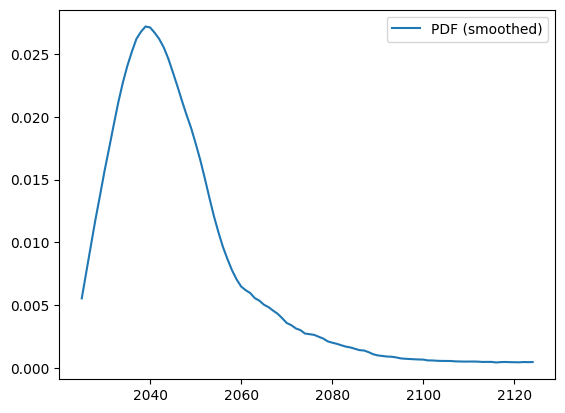

-
-
## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.1,
 10: 25.9,
 20: 26.9,
 30: 28.1,
 40: 29.6,
 50: 31.4,
 60: 33.0,
 70: 35.2,
 80: 37.7,
 90: 41.3,
 95: 43.6,
 99: 49.3}
(Mean: 32.5)


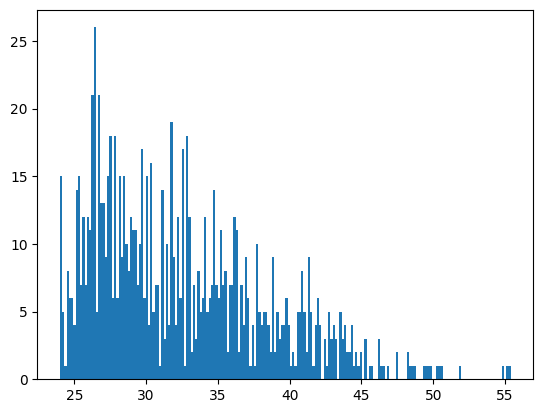

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 21.7,
 5: 15.4,
 10: 12.4,
 20: 10.3,
 30: 8.7,
 40: 7.6,
 50: 6.7,
 60: 5.9,
 70: 5.1,
 80: 4.4,
 90: 3.4,
 95: 3.0,
 99: 2.0}
(Mean: 7.6)


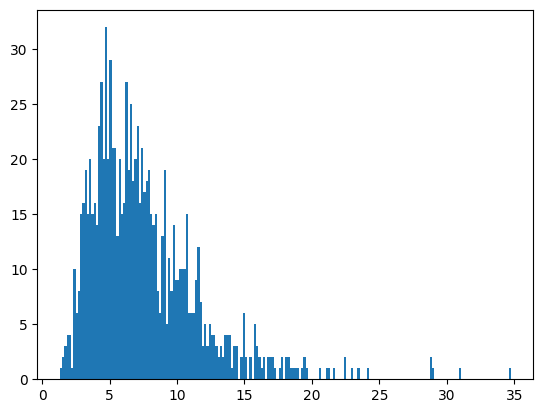

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.8,
 5: 18.0,
 10: 18.1,
 20: 18.2,
 30: 18.3,
 40: 18.4,
 50: 18.5,
 60: 18.6,
 70: 18.6,
 80: 18.7,
 90: 18.9,
 95: 19.0,
 99: 19.2}
(Mean: 18.5)


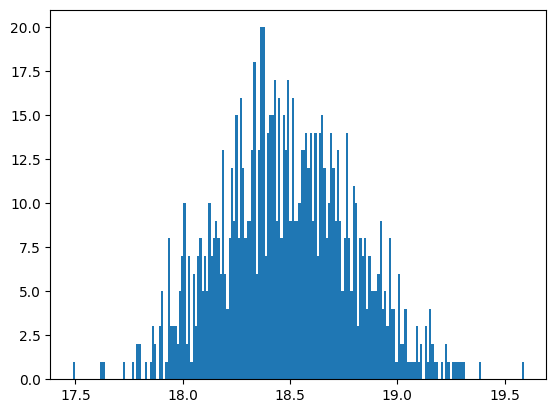

-
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}
(Mean: 2.5)


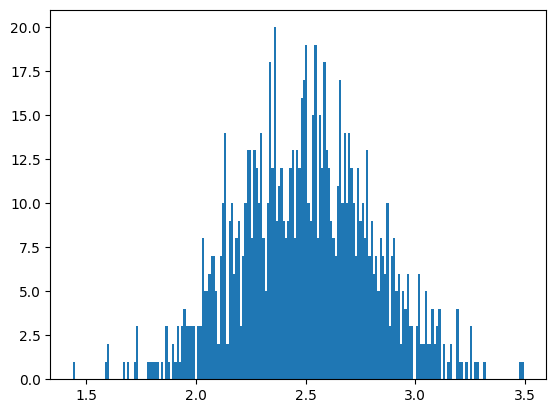

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.0,
 5: 21.0,
 10: 21.5,
 20: 22.1,
 30: 22.6,
 40: 23.0,
 50: 23.5,
 60: 23.9,
 70: 24.3,
 80: 24.8,
 90: 25.4,
 95: 26.0,
 99: 26.8}
(Mean: 23.5)


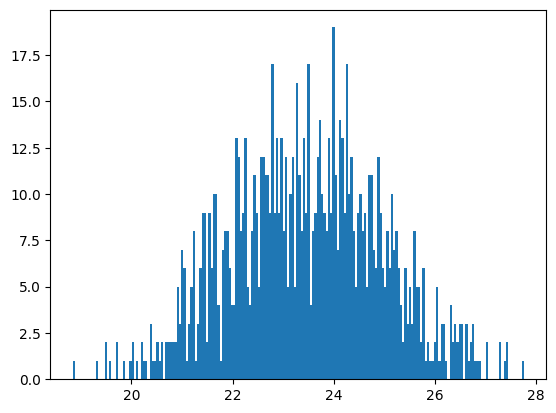

-
-
## INITIAL PAY ##
{1: 8.3,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.6,
 40: 8.7,
 50: 8.8,
 60: 8.8,
 70: 8.9,
 80: 9.0,
 90: 9.1,
 95: 9.3,
 99: 9.6}
(Mean: 8.8)


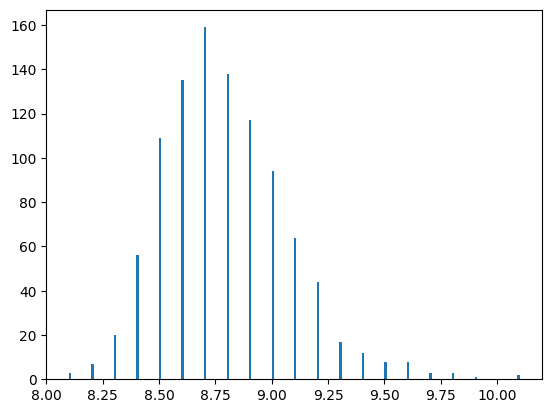

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


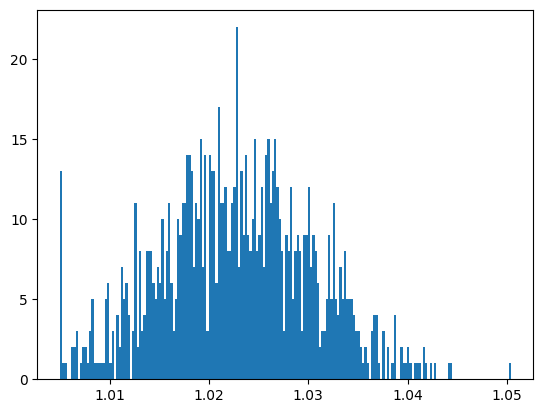

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00029,
 40: 0.00036,
 50: 0.00047,
 60: 0.00062,
 70: 0.00089,
 80: 0.00165,
 90: 0.00366,
 95: 0.00524,
 99: 0.01212}
(Mean: 0.0)


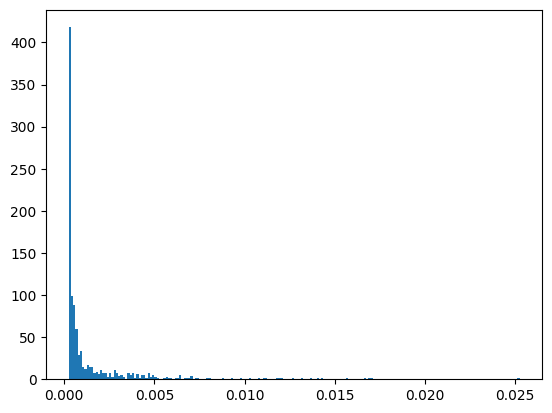

-
-
## SPEND DOUBLING TIME ##
{1: 13.3,
 5: 9.2,
 10: 7.1,
 20: 5.2,
 30: 4.0,
 40: 3.4,
 50: 2.9,
 60: 2.4,
 70: 2.1,
 80: 1.7,
 90: 1.3,
 95: 1.0,
 99: 0.9}
(Mean: 3.7)


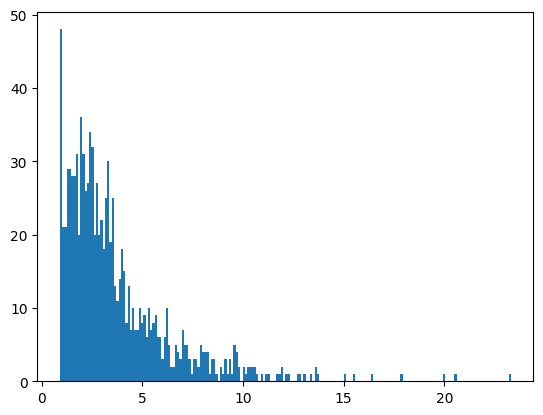

-
-
-
-
## GDP Over Time ##


TypeError: loop of ufunc does not support argument 0 of type ComplexDistribution which has no callable log10 method

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


In [ ]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [ ]:
print('File last ran: {}'.format(dt.now()))